In [20]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import sys

from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

from src.evaluation import ModelComparator
from src.feature_importance import FeatureImportanceAnalyzer

In [21]:
DATA_DIR = Path('Data')

# Load X metrics and Y targets
X_metrics_df = pd.read_csv(DATA_DIR / 'X' / 'X_metrics.csv')
Y_df = pd.read_csv(DATA_DIR / 'Y' / 'Y.csv')

print(f"X Metrics: {X_metrics_df.shape}")
print(f"Y Targets: {Y_df.shape}")

# Verify alignment by merging on ID columns
data = X_metrics_df.merge(Y_df[['filename', 'VehId', 'DayNum', 'Trip', 
                                   'Y_consumption_combustion_L_per_100km', 
                                   'Y_consumption_electric_kWh_per_km']], 
                          on=['filename', 'VehId', 'DayNum', 'Trip'], 
                          how='inner')

print(f"\nMerged X and Y: {data.shape[0]} samples")
print(f"X columns: {X_metrics_df.shape[1]}")
print(f"Y columns: 2 (combustion L/100km, electric kWh/km)")
print(f"\nFirst few rows:")
print(data.head())

X Metrics: (32541, 108)
Y Targets: (32541, 6)

Merged X and Y: 32541 samples
X columns: 108
Y columns: 2 (combustion L/100km, electric kWh/km)

First few rows:
                    filename  VehId    DayNum  Trip  Absolute Load[%]_mean  \
0  Trip_1558_VED_171101_week     10  1.719774  1558                    0.0   
1  Trip_1561_VED_171101_week     10  2.893902  1561                    0.0   
2  Trip_1567_VED_171101_week     10  4.540203  1567                    0.0   
3  Trip_1568_VED_171101_week     10  4.575309  1568                    0.0   
4  Trip_1572_VED_171101_week     10  4.941220  1572                    0.0   

   Absolute Load[%]_median  Absolute Load[%]_std  Absolute Load[%]_min  \
0                      0.0                   0.0                   0.0   
1                      0.0                   0.0                   0.0   
2                      0.0                   0.0                   0.0   
3                      0.0                   0.0                   0.0   
4

In [22]:
# Define exclusion columns (exclude from features, but keep ID columns for tracking)
exclude_cols = ['filename', 'DayNum', 'Trip', 'Timestamp', 'Timestamp(ms)',
                'Y_consumption_combustion_L_per_100km', 'Y_consumption_electric_kWh_per_km']

# Keep VehId for identification
veh_ids = data['VehId'].values if 'VehId' in data.columns else None

# Get numeric feature columns (excluding non-numeric and identifiers)
feature_cols = [col for col in data.columns 
               if col not in exclude_cols 
               and col != 'VehId'  # Explicitly exclude VehId from features
               and col != 'filename'
               and data[col].dtype in [np.float64, np.int64]]

print(f"Total features selected: {len(feature_cols)}")
print(f"First 10 features: {feature_cols[:10]}")
print(f"VehId preserved for vehicle identification: {veh_ids is not None}")

# Prepare X and y
X = data[feature_cols].fillna(data[feature_cols].mean())

# Use the combustion target for metrics analysis
target_col = 'Y_consumption_combustion_L_per_100km'
y = data[target_col].fillna(data[target_col].mean()).values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable: {target_col}")
print(f"Target shape: {y.shape}")
print(f"Target - Mean: {y.mean():.4f}, Std: {y.std():.4f}, Min: {y.min():.4f}, Max: {y.max():.4f}")

Total features selected: 104
First 10 features: ['Absolute Load[%]_mean', 'Absolute Load[%]_median', 'Absolute Load[%]_std', 'Absolute Load[%]_min', 'Absolute Load[%]_max', 'Absolute Load[%]_q25', 'Absolute Load[%]_q75', 'Absolute Load[%]_range', 'Air Conditioning Power[Watts]_mean', 'Air Conditioning Power[Watts]_median']
VehId preserved for vehicle identification: True

Feature matrix shape: (32541, 104)
Target variable: Y_consumption_combustion_L_per_100km
Target shape: (32541,)
Target - Mean: 0.1021, Std: 1.0899, Min: 0.0000, Max: 30.0697


In [23]:
# Split: 80% dev (for train+val), 20% test
# Then dev split: 80% train, 20% val from dev

# Create indices for splitting while preserving VehId
indices = np.arange(len(X))

# First split: dev (80%) vs test (20%)
idx_dev, idx_test, X_dev, X_test, y_dev, y_test = train_test_split(
    indices, X, y, test_size=0.2, random_state=69
)

# Get VehIds for each split if available
if veh_ids is not None:
    veh_ids_dev = veh_ids[idx_dev]
    veh_ids_test = veh_ids[idx_test]
else:
    veh_ids_dev = None
    veh_ids_test = None

print(f"Dev set: {X_dev.shape[0]} samples ({len(X_dev)/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({len(X_test)/len(X)*100:.1f}%)")

# Second split: dev into train (80% of dev ≈ 64% of total) vs val (20% of dev ≈ 16% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_dev, y_dev, test_size=0.2, random_state=69
)

if veh_ids_dev is not None:
    veh_ids_train = veh_ids_dev[:len(X_train)]
    veh_ids_val = veh_ids_dev[len(X_train):]
else:
    veh_ids_train = None
    veh_ids_val = None

print(f"Train set: {X_train.shape[0]} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val set: {X_val.shape[0]} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify split
total = len(X_train) + len(X_val) + len(X_test)
print(f"\nTotal samples: {total}")
print(f"Train: {len(X_train)/total*100:.1f}% | Val: {len(X_val)/total*100:.1f}% | Test: {len(X_test)/total*100:.1f}%")

# Store VehId information for later use
print(f"\nVehId information preserved:")
if veh_ids_train is not None:
    print(f"Train VehIds: {len(veh_ids_train)} cars")
    print(f"Val VehIds: {len(veh_ids_val)} cars")
    print(f"Test VehIds: {len(veh_ids_test)} cars")


Dev set: 26032 samples (80.0%)
Test set: 6509 samples (20.0%)
Train set: 20825 samples (64.0%)
Val set: 5207 samples (16.0%)
Test set: 6509 samples (20.0%)

Total samples: 32541
Train: 64.0% | Val: 16.0% | Test: 20.0%

VehId information preserved:
Train VehIds: 20825 cars
Val VehIds: 5207 cars
Test VehIds: 6509 cars


In [24]:
# Create scaler and fit on training data ONLY
scaler = StandardScaler()
scaler.fit(X_train)

# Scale all sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrames for easier handling (optional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)
 
# Sanitize feature names for XGBoost (remove special characters)
sanitized_feature_cols = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in feature_cols]
X_train_scaled.columns = sanitized_feature_cols
X_val_scaled.columns = sanitized_feature_cols
X_test_scaled.columns = sanitized_feature_cols

print(f"Train set shape: {X_train_scaled.shape}")
print(f"Val set shape: {X_val_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"\nFeature statistics after scaling (train):")
print(f"Mean: {X_train_scaled.mean().mean():.6f}")
print(f"Std: {X_train_scaled.std().mean():.6f}")


Train set shape: (20825, 104)
Val set shape: (5207, 104)
Test set shape: (6509, 104)

Feature statistics after scaling (train):
Mean: 0.000000
Std: 1.000024


In [25]:
# Initialize dictionaries to store models and predictions
all_models = {}
all_predictions = {}
metrics_dict = {}

def calculate_metrics(y_true, y_pred):
    """Calculate evaluation metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.abs(y_true))) * 100 if np.all(y_true != 0) else np.nan
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

# -------- LightGBM (using native API) --------
print("\n→ Training LightGBM...")
train_data = lgb.Dataset(X_train_scaled, label=y_train)
valid_data = lgb.Dataset(X_val_scaled, label=y_val, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 7,
    'verbose': -1
}

model_lgbm = lgb.train(params, train_data, num_boost_round=300, valid_sets=[valid_data])
preds_lgbm = model_lgbm.predict(X_test_scaled.values)

all_models['LightGBM'] = model_lgbm
all_predictions['LightGBM'] = preds_lgbm
metrics = calculate_metrics(y_test, preds_lgbm)
metrics_dict['LightGBM'] = metrics
print(f"Trained - RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")

print(f"\nAll models trained: {list(all_models.keys())}")


→ Training LightGBM...
Trained - RMSE: 0.3610, R²: 0.8820

All models trained: ['LightGBM']
Trained - RMSE: 0.3610, R²: 0.8820

All models trained: ['LightGBM']


In [26]:
# -------- Train Remaining Models --------

# Random Forest
print("\n→ Training Random Forest...")
model_rf = RandomForestRegressor(n_estimators=100, random_state=69, n_jobs=-1, max_depth=15)
model_rf.fit(X_train_scaled, y_train)
preds_rf = model_rf.predict(X_test_scaled)
all_models['Random Forest'] = model_rf
all_predictions['Random Forest'] = preds_rf
metrics = calculate_metrics(y_test, preds_rf)
metrics_dict['Random Forest'] = metrics
print(f"Trained - RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")

# XGBoost
print("\n→ Training XGBoost...")
model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=69, n_jobs=-1)
model_xgb.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=False)
preds_xgb = model_xgb.predict(X_test_scaled)
all_models['XGBoost'] = model_xgb
all_predictions['XGBoost'] = preds_xgb
metrics = calculate_metrics(y_test, preds_xgb)
metrics_dict['XGBoost'] = metrics
print(f"Trained - RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")

# Linear OLS
print("\n→ Training Linear OLS...")
model_ols = LinearRegression()
model_ols.fit(X_train_scaled, y_train)
preds_ols = model_ols.predict(X_test_scaled)
all_models['Linear OLS'] = model_ols
all_predictions['Linear OLS'] = preds_ols
metrics = calculate_metrics(y_test, preds_ols)
metrics_dict['Linear OLS'] = metrics
print(f"Trained - RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")

# Linear Ridge
print("\n→ Training Linear Ridge...")
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train_scaled, y_train)
preds_ridge = model_ridge.predict(X_test_scaled)
all_models['Linear Ridge'] = model_ridge
all_predictions['Linear Ridge'] = preds_ridge
metrics = calculate_metrics(y_test, preds_ridge)
metrics_dict['Linear Ridge'] = metrics
print(f"Trained - RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")

# Linear Lasso
print("\n→ Training Linear Lasso...")
model_lasso = Lasso(alpha=0.001)
model_lasso.fit(X_train_scaled, y_train)
preds_lasso = model_lasso.predict(X_test_scaled)
all_models['Linear Lasso'] = model_lasso
all_predictions['Linear Lasso'] = preds_lasso
metrics = calculate_metrics(y_test, preds_lasso)
metrics_dict['Linear Lasso'] = metrics
print(f"Trained - RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")

print(f"\n✓ All models trained successfully!")
print(f"Models: {list(all_models.keys())}")


→ Training Random Forest...
Trained - RMSE: 0.3579, R²: 0.8840

→ Training XGBoost...
Trained - RMSE: 0.3579, R²: 0.8840

→ Training XGBoost...
Trained - RMSE: 0.3358, R²: 0.8979

→ Training Linear OLS...
Trained - RMSE: 0.9732, R²: 0.1423

→ Training Linear Ridge...
Trained - RMSE: 0.9733, R²: 0.1422

→ Training Linear Lasso...
Trained - RMSE: 0.3358, R²: 0.8979

→ Training Linear OLS...
Trained - RMSE: 0.9732, R²: 0.1423

→ Training Linear Ridge...
Trained - RMSE: 0.9733, R²: 0.1422

→ Training Linear Lasso...
Trained - RMSE: 0.9700, R²: 0.1481

✓ All models trained successfully!
Models: ['LightGBM', 'Random Forest', 'XGBoost', 'Linear OLS', 'Linear Ridge', 'Linear Lasso']
Trained - RMSE: 0.9700, R²: 0.1481

✓ All models trained successfully!
Models: ['LightGBM', 'Random Forest', 'XGBoost', 'Linear OLS', 'Linear Ridge', 'Linear Lasso']


In [27]:
comparator = ModelComparator()

for model_name, predictions in all_predictions.items():
    comparator.add_model_results(model_name, y_test, predictions)

comparator.print_summary()

comparison_df = comparator.get_comparison_dataframe()
print("\nDetailed Comparison Table:")
print(comparison_df.round(6).to_string())

# Create results directory if it doesn't exist
Path('results').mkdir(exist_ok=True)

comparison_df.to_csv('results/model_comparison.csv')

if veh_ids_test is not None:
    detailed_results = pd.DataFrame({
        'VehId': veh_ids_test,
        'Actual': y_test
    })
    
    for model_name, predictions in all_predictions.items():
        detailed_results[f'{model_name}_Pred'] = predictions
    
    detailed_results.to_csv('results/model_predictions_with_vehicles.csv', index=False)
    print(f"Detailed predictions with vehicle IDs saved to results/model_predictions_with_vehicles.csv")
    print(f"Samples: {len(detailed_results)} test vehicles")


MODEL COMPARISON SUMMARY
                   RMSE       MAE        R2  MAPE       MSE  Training Time
LightGBM       0.361012  0.051697  0.881989   inf  0.130329            0.0
Random Forest  0.357922  0.031874  0.884000   NaN  0.128108            0.0
XGBoost        0.335842  0.030461  0.897871   inf  0.112790            0.0
Linear OLS     0.973236  0.370969  0.142335   inf  0.947189            0.0
Linear Ridge   0.973291  0.370787  0.142238   inf  0.947296            0.0
Linear Lasso   0.969968  0.364128  0.148086   inf  0.940838            0.0

BEST MODELS:
  RMSE:  XGBoost (0.335842)
  MAE:   XGBoost (0.030461)
  R²:    XGBoost (0.897871)
  MAPE:  LightGBM (inf%)


Detailed Comparison Table:
                   RMSE       MAE        R2  MAPE       MSE  Training Time
LightGBM       0.361012  0.051697  0.881989   inf  0.130329            0.0
Random Forest  0.357922  0.031874  0.884000   NaN  0.128108            0.0
XGBoost        0.335842  0.030461  0.897871   inf  0.112790            0

In [28]:
project_path = '/media/vanafa/1TB/Workspace/Cuatri 6/ML/TP Final'
if project_path not in sys.path:
    sys.path.insert(0, project_path)

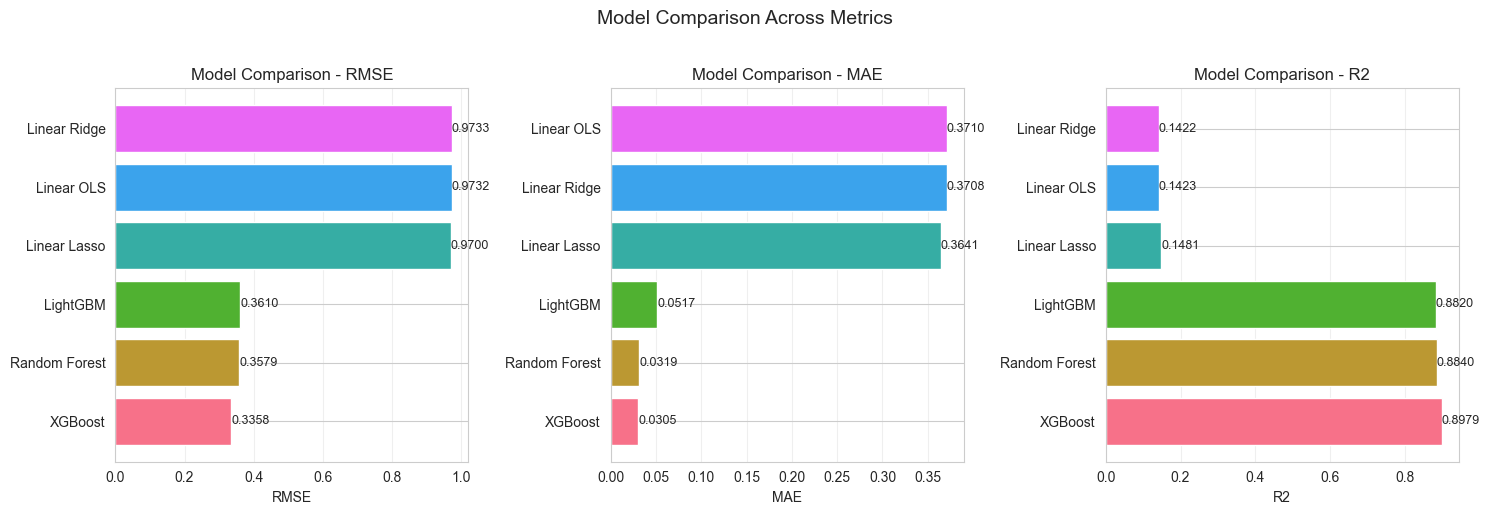


Best model: XGBoost (RMSE: 0.335842)


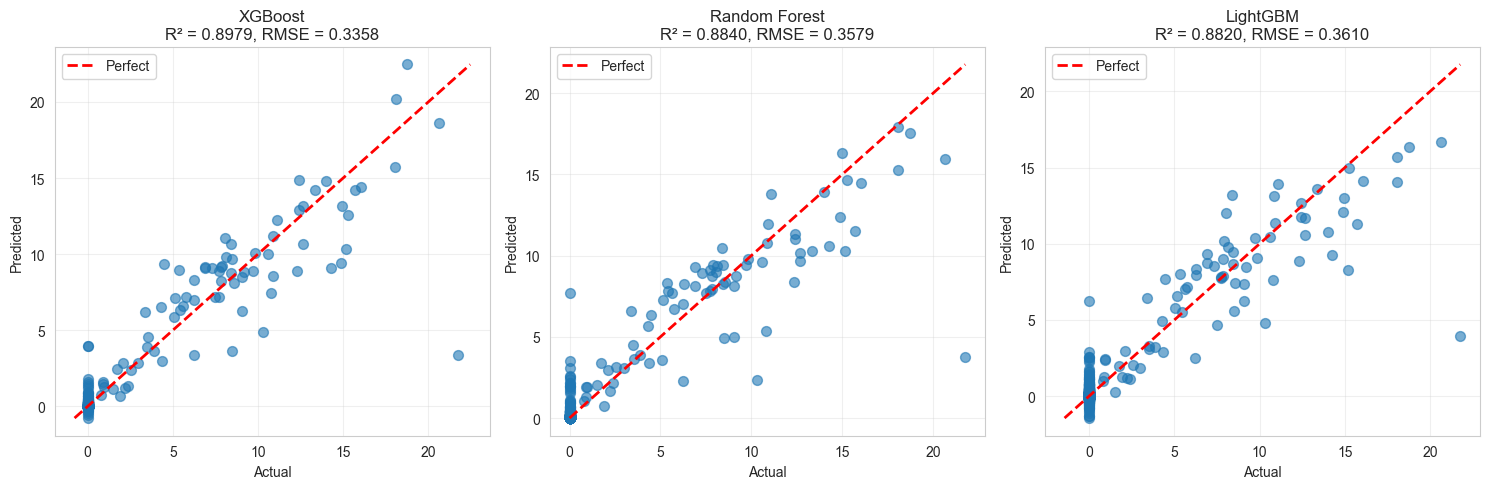

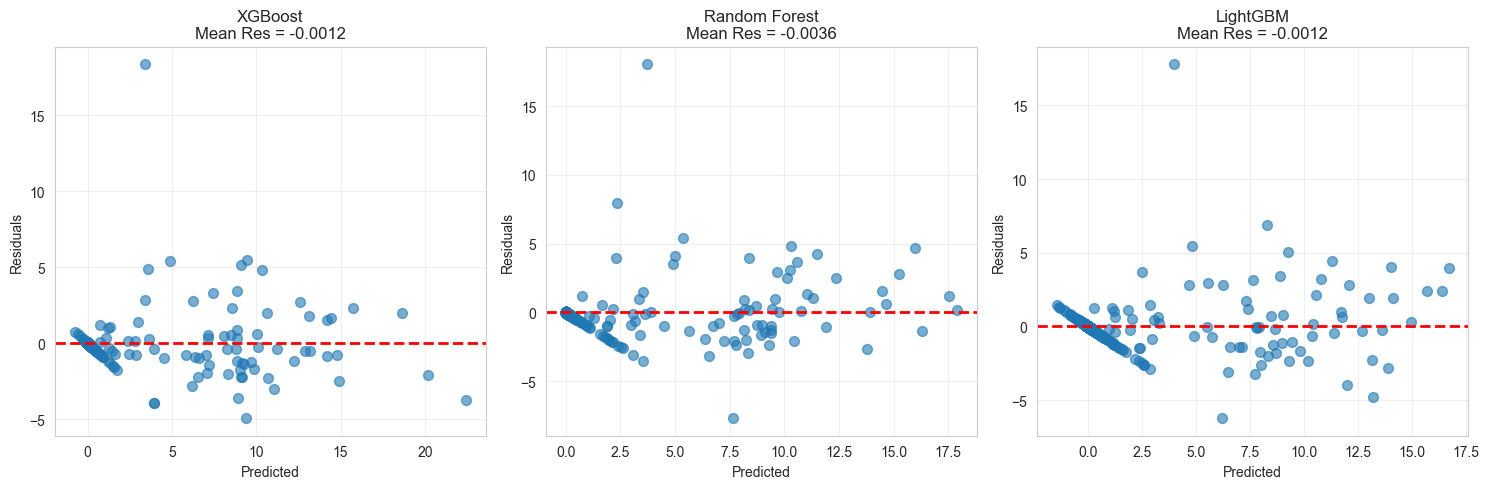

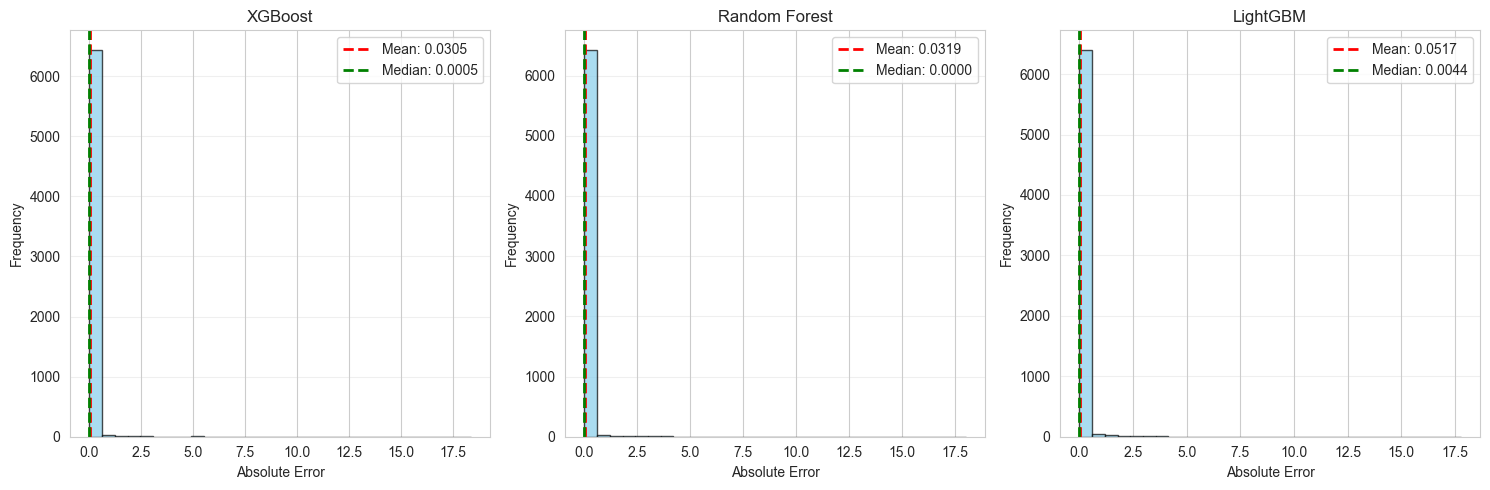

In [29]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

# 1. Model Comparison - RMSE
fig = comparator.plot_comparison(metrics=['RMSE', 'MAE', 'R2'], figsize=(15, 5))
plt.suptitle('Model Comparison Across Metrics', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('results/model_comparison_metrics.png', dpi=100, bbox_inches='tight')
plt.show()

# 2. Predictions vs Actual for top 3 models
best_model_name, best_rmse = comparator.get_best_model('RMSE')
print(f"\nBest model: {best_model_name} (RMSE: {best_rmse:.6f})")

# Get top 3 models by RMSE
top_3_models = comparison_df['RMSE'].nsmallest(3).index.tolist()
top_3_preds = {name: all_predictions[name] for name in top_3_models}

fig = plt.figure(figsize=(15, 5))
for idx, (model_name, preds) in enumerate(top_3_preds.items(), 1):
    ax = plt.subplot(1, 3, idx)
    
    r2 = comparison_df.loc[model_name, 'R2']
    rmse = comparison_df.loc[model_name, 'RMSE']
    
    ax.scatter(y_test, preds, alpha=0.6, s=50)
    
    # Perfect prediction line
    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
    
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{model_name}\nR² = {r2:.4f}, RMSE = {rmse:.4f}')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('results/predictions_vs_actual_top3.png', dpi=100, bbox_inches='tight')
plt.show()

# 3. Residuals plot for top 3 models
fig = plt.figure(figsize=(15, 5))
for idx, (model_name, preds) in enumerate(top_3_preds.items(), 1):
    ax = plt.subplot(1, 3, idx)
    
    residuals = y_test - preds
    
    ax.scatter(preds, residuals, alpha=0.6, s=50)
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Residuals')
    ax.set_title(f'{model_name}\nMean Res = {residuals.mean():.4f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/residuals_top3.png', dpi=100, bbox_inches='tight')
plt.show()

# 4. Error distribution for top 3 models
fig = plt.figure(figsize=(15, 5))
for idx, (model_name, preds) in enumerate(top_3_preds.items(), 1):
    ax = plt.subplot(1, 3, idx)
    
    errors = np.abs(y_test - preds)
    
    ax.hist(errors, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    ax.axvline(errors.mean(), color='r', linestyle='--', lw=2, label=f'Mean: {errors.mean():.4f}')
    ax.axvline(np.median(errors), color='g', linestyle='--', lw=2, label=f'Median: {np.median(errors):.4f}')
    
    ax.set_xlabel('Absolute Error')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/error_distribution_top3.png', dpi=100, bbox_inches='tight')
plt.show()

Added Random Forest feature importances
Added XGBoost feature importances
Added Linear OLS coefficients
Added Linear Ridge coefficients
Added Linear Lasso coefficients

FEATURE IMPORTANCE ANALYSIS


Random Forest - Top 15 Features:
------------------------------------------------------------
   1. Engine RPM[RPM]_q75                          0.192888
   2. Engine RPM[RPM]_std                          0.130329
   3. Engine RPM[RPM]_min                          0.051329
   4. HV Battery SOC[%]_max                        0.037871
   5. Engine RPM[RPM]_max                          0.036960
   6. Vehicle Speed[km/h]_max                      0.036670
   7. Engine RPM[RPM]_mean                         0.035584
   8. HV Battery SOC[%]_mean                       0.026233
   9. Vehicle Speed[km/h]_q25                      0.025306
  10. Air Conditioning Power[kW]_std               0.024589
  11. Air Conditioning Power[kW]_range             0.023247
  12. Short Term Fuel Trim Bank 1[%]_std       

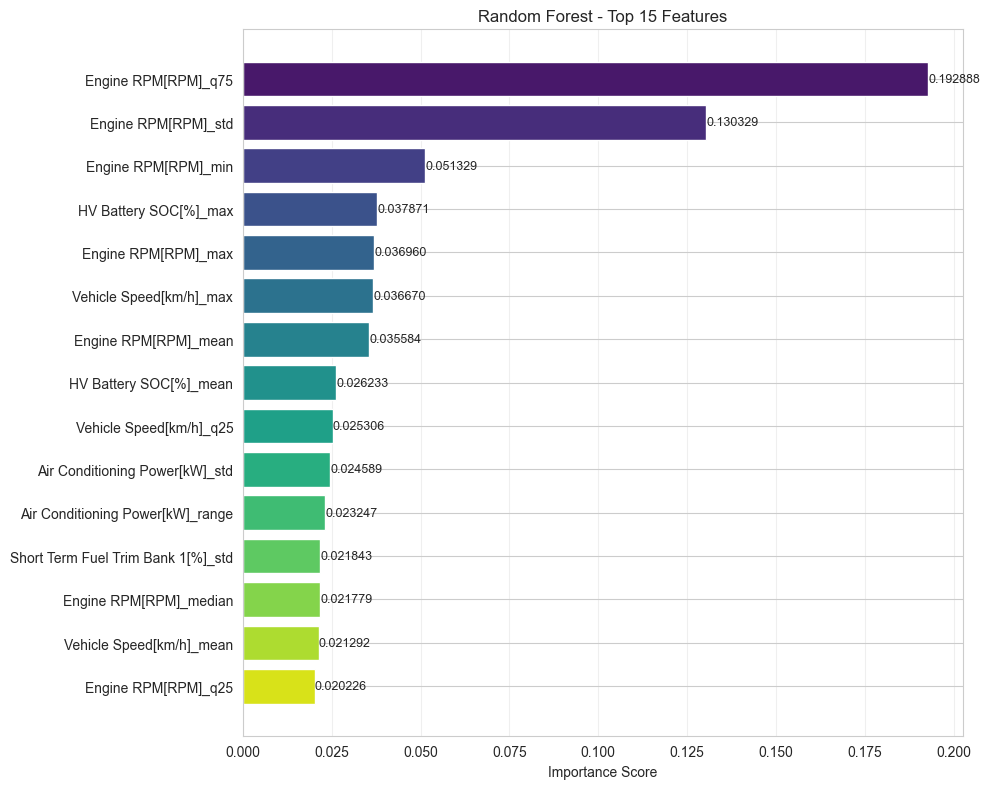

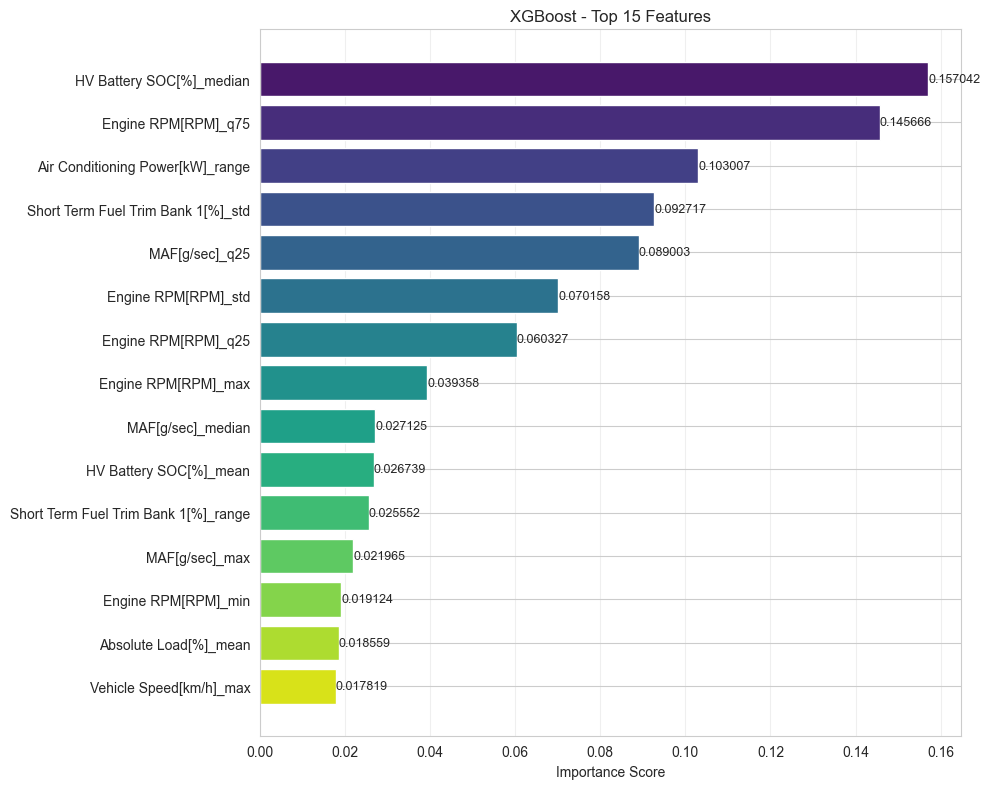

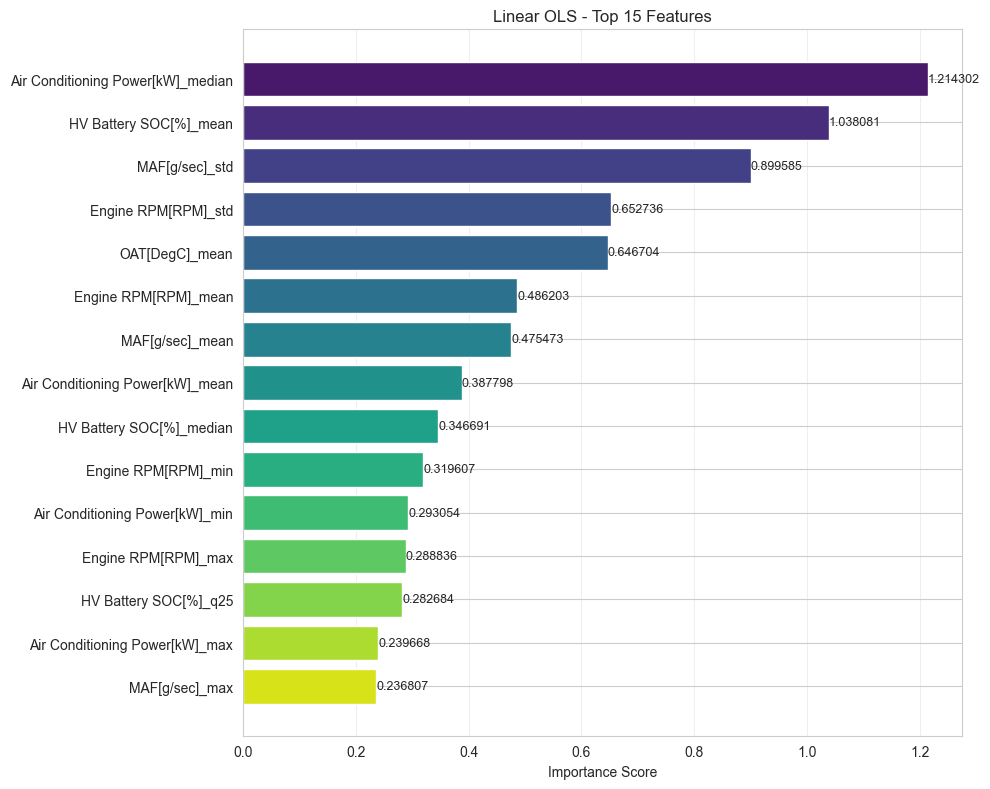

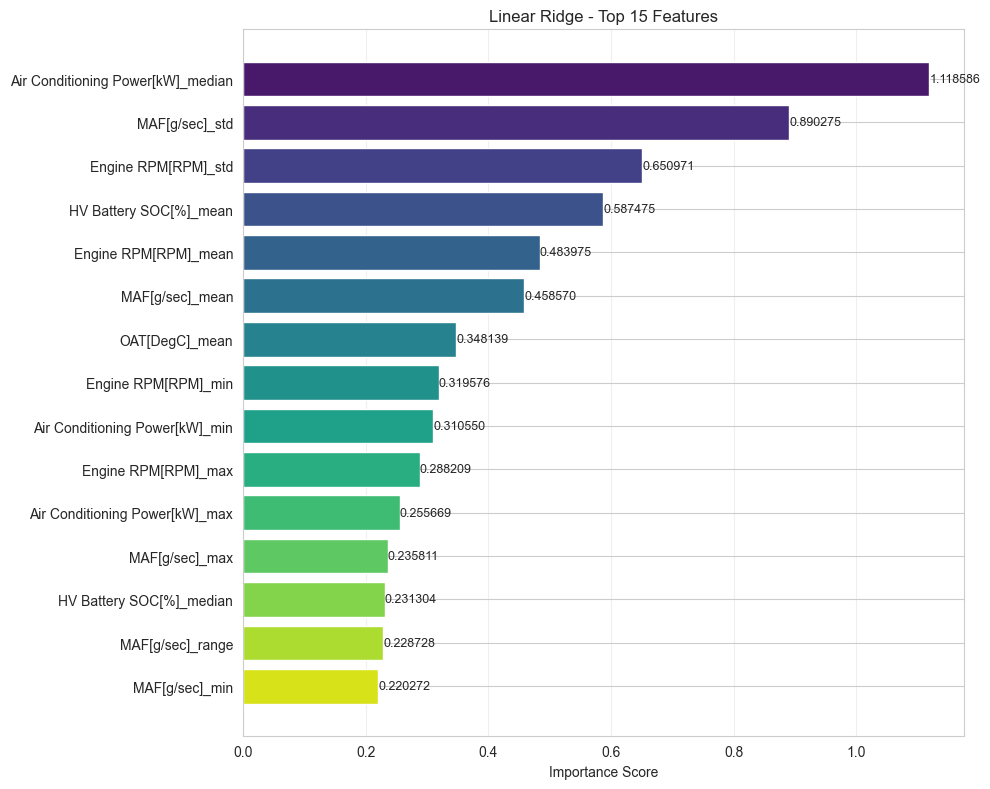

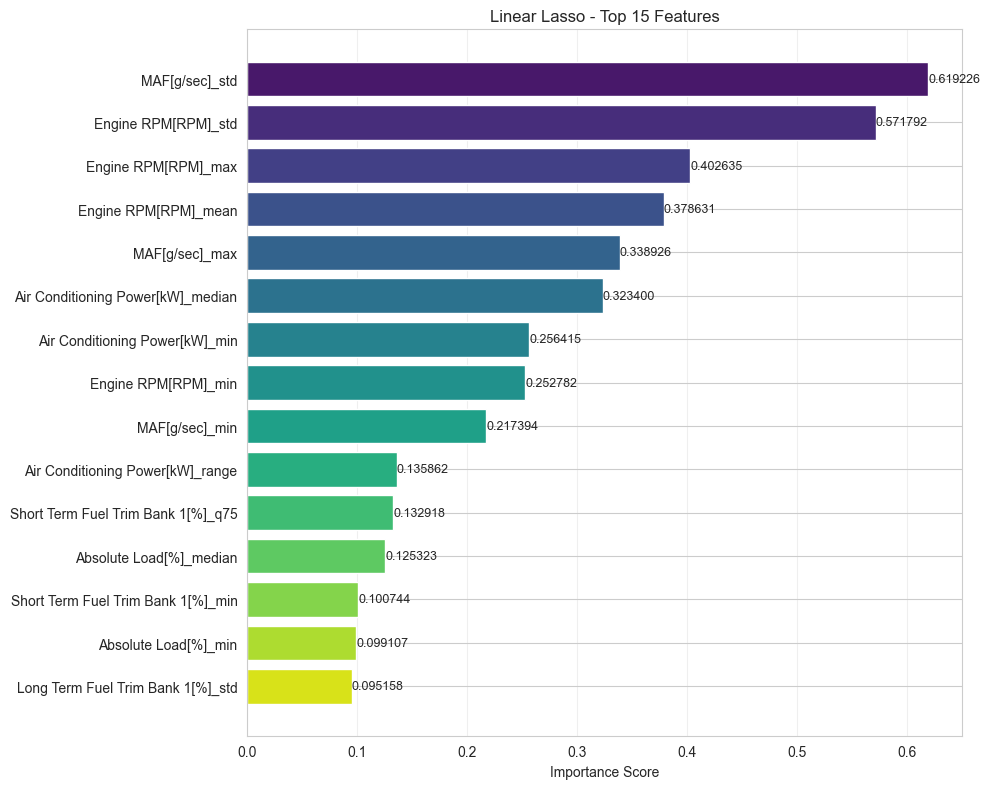

In [30]:
analyzer = FeatureImportanceAnalyzer(feature_cols)

# Extract feature importance from tree-based models
if hasattr(all_models['Random Forest'], 'feature_importances_'):
    importance = all_models['Random Forest'].feature_importances_
    analyzer.add_importance('Random Forest', importance, 'importance')
    print("Added Random Forest feature importances")

if hasattr(all_models['XGBoost'], 'feature_importances_'):
    importance = all_models['XGBoost'].feature_importances_
    analyzer.add_importance('XGBoost', importance, 'importance')
    print("Added XGBoost feature importances")

if hasattr(all_models['LightGBM'], 'feature_importances_'):
    importance = all_models['LightGBM'].feature_importances_
    analyzer.add_importance('LightGBM', importance, 'importance')
    print("Added LightGBM feature importances")

# Add linear coefficients (absolute values)
if hasattr(all_models['Linear OLS'], 'coef_'):
    importance = np.abs(all_models['Linear OLS'].coef_)
    analyzer.add_importance('Linear OLS', importance, 'coefficient')
    print("Added Linear OLS coefficients")

if hasattr(all_models['Linear Ridge'], 'coef_'):
    importance = np.abs(all_models['Linear Ridge'].coef_)
    analyzer.add_importance('Linear Ridge', importance, 'coefficient')
    print("Added Linear Ridge coefficients")

if hasattr(all_models['Linear Lasso'], 'coef_'):
    importance = np.abs(all_models['Linear Lasso'].coef_)
    analyzer.add_importance('Linear Lasso', importance, 'coefficient')
    print("Added Linear Lasso coefficients")

# Print summary
analyzer.print_summary(n=15)

# Plot feature importance for all models
Path('results').mkdir(exist_ok=True)
for model_name in ['Random Forest', 'XGBoost', 'LightGBM', 'Linear OLS', 'Linear Ridge', 'Linear Lasso']:
    if model_name in analyzer.importances:
        fig = analyzer.plot_feature_importance(model_name, n=15, figsize=(10, 8))
        plt.tight_layout()
        plt.savefig(f'results/feature_importance_{model_name.lower().replace(" ", "_")}.png', 
                   dpi=100, bbox_inches='tight')
        plt.show()

In [31]:
best_model_name, best_rmse = comparator.get_best_model('RMSE')
best_mae = comparator.get_best_model('MAE')[1]
best_r2 = comparator.get_best_model('R2')[1]

print(f"\nBEST MODEL: {best_model_name}")
print(f"RMSE: {best_rmse:.6f}")
print(f"MAE:  {best_mae:.6f}")
print(f"R²:   {best_r2:.6f}")

print("\nMODEL RANKING (by RMSE):")
ranking = comparison_df.sort_values('RMSE')
for i, (model, row) in enumerate(ranking.iterrows(), 1):
    print(f"{i}. {model:20s} | RMSE: {row['RMSE']:10.6f} | MAE: {row['MAE']:10.6f} | R²: {row['R2']:8.6f}")

print("\nMETRICS INTERPRETATION")
print("""
RMSE (Root Mean Squared Error):
  - Average magnitude of prediction errors
  - Lower is better
  - Same units as target variable

MAE (Mean Absolute Error):
  - Average absolute prediction error
  - More interpretable than RMSE
  - Lower is better

R² (Coefficient of Determination):
  - Proportion of variance explained by model
  - 1.0 = perfect, 0.0 = no better than mean
  - Higher is better

MAPE (Mean Absolute Percentage Error):
  - Percentage error relative to actual values
  - Useful for comparing across scales
  - Lower is better (%)
""")

# Create directories if they don't exist
Path('models/saved_models').mkdir(parents=True, exist_ok=True)

# Save all models with joblib
for model_name, model in all_models.items():
    joblib.dump(model, f'models/saved_models/{model_name.replace(" ", "_")}.pkl')
    print(f"Saved {model_name}")

# Save scaler
joblib.dump(scaler, 'models/saved_models/feature_scaler.pkl')
print("Saved feature scaler")

print(f"""
Results saved to:
  - results/model_comparison.csv (metrics table)
  - results/model_comparison_metrics.png (comparison plot)
  - results/predictions_vs_actual_top3.png (predictions plot)
  - results/residuals_top3.png (residuals plot)
  - results/error_distribution_top3.png (error distribution)
  - results/feature_importance_*.png (feature importance plots)

Models saved to:
  - models/saved_models/[model_name].pkl
  - models/saved_models/feature_scaler.pkl
""")


BEST MODEL: XGBoost
RMSE: 0.335842
MAE:  0.030461
R²:   0.897871

MODEL RANKING (by RMSE):
1. XGBoost              | RMSE:   0.335842 | MAE:   0.030461 | R²: 0.897871
2. Random Forest        | RMSE:   0.357922 | MAE:   0.031874 | R²: 0.884000
3. LightGBM             | RMSE:   0.361012 | MAE:   0.051697 | R²: 0.881989
4. Linear Lasso         | RMSE:   0.969968 | MAE:   0.364128 | R²: 0.148086
5. Linear OLS           | RMSE:   0.973236 | MAE:   0.370969 | R²: 0.142335
6. Linear Ridge         | RMSE:   0.973291 | MAE:   0.370787 | R²: 0.142238

METRICS INTERPRETATION

RMSE (Root Mean Squared Error):
  - Average magnitude of prediction errors
  - Lower is better
  - Same units as target variable

MAE (Mean Absolute Error):
  - Average absolute prediction error
  - More interpretable than RMSE
  - Lower is better

R² (Coefficient of Determination):
  - Proportion of variance explained by model
  - 1.0 = perfect, 0.0 = no better than mean
  - Higher is better

MAPE (Mean Absolute Percentage